In [59]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2
import matplotlib.pyplot as plt


# EDA

In [60]:
cv2.imread('/kaggle/input/parking-lot-dataset/PKLot/PKLotSegmented/PUC/Cloudy/2012-09-12/Empty/2012-09-12_06_05_16#003.jpg').shape

(52, 32, 3)

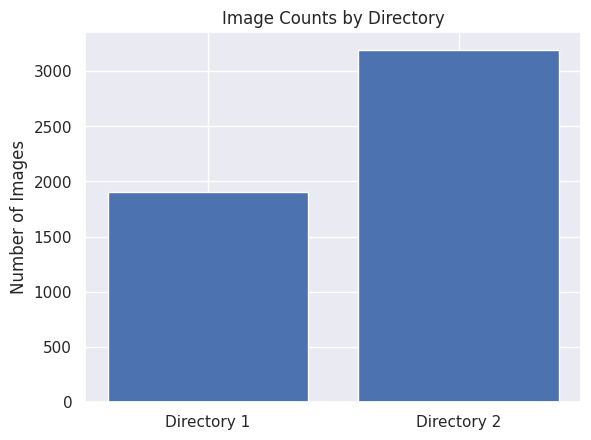

In [61]:
# Define the paths to the directories
dir1_path = "/kaggle/input/parking-lot-dataset/PKLot/PKLotSegmented/PUC/Cloudy/2012-09-12/Empty"
dir2_path = "/kaggle/input/parking-lot-dataset/PKLot/PKLotSegmented/PUC/Cloudy/2012-09-12/Occupied"

# Get the number of images in each directory
dir1_count = len(os.listdir(dir1_path))
dir2_count = len(os.listdir(dir2_path))

# Plot the number of images in each directory
fig, ax = plt.subplots()
ax.bar(["Directory 1", "Directory 2"], [dir1_count, dir2_count])
ax.set_ylabel("Number of Images")
ax.set_title("Image Counts by Directory")
plt.show()

In [62]:
(dir1_count + dir2_count) / dir1_count

2.678928008407777

In [63]:
(dir1_count + dir2_count) / dir2_count

1.5956181533646323

In [64]:
class_weights = {0: (dir1_count + dir2_count) / dir1_count, 1: (dir1_count + dir2_count) / dir2_count}

# Read Data

In [65]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

input_shape = (100,100,3)

x_train = np.ndarray((1, 100, 100, 3))
y_train = np.ndarray((1, 2))
x_val = np.ndarray((1, 100, 100, 3))
y_val = np.ndarray((1, 2))

# Define the path to the directory containing the images
for folder_name in os.listdir('/kaggle/input/parking-lot-dataset/PKLot/PKLotSegmented/PUC/Cloudy'):
    train_dir = f"/kaggle/input/parking-lot-dataset/PKLot/PKLotSegmented/PUC/Cloudy/{folder_name}"

    # Define the input shape and number of classes for your dataset
    num_classes = 2

    # Define the image data generator with augmentation parameters
    augment_datagen = ImageDataGenerator(
            rescale=1./255,
            shear_range=0.1,
            rotation_range=20,
            zoom_range=0.1,
            horizontal_flip=True,
            vertical_flip=True,
            validation_split=0.2)

    # Load the images into separate folders based on their class labels
    train_generator = augment_datagen.flow_from_directory(
            train_dir,
            shuffle=True,
            seed=42,
            target_size=input_shape[:2],
            batch_size=256,
            class_mode='categorical',
            subset='training')

    validation_generator = augment_datagen.flow_from_directory(
            train_dir,
            target_size=input_shape[:2],
            batch_size=256,
            shuffle=True,
            seed=42,
            class_mode='categorical',
            subset='validation')

    x_tr, y_tr = next(train_generator)
    x_v, y_v = next(validation_generator)
    
    x_val = np.append(x_val, x_v, axis=0)
    y_val = np.append(y_val, y_v, axis=0)
    
    x_train = np.append(x_train, x_tr[:500], axis=0)
    y_train = np.append(y_train, y_tr[:500], axis=0)

Found 6321 images belonging to 2 classes.
Found 1579 images belonging to 2 classes.
Found 12399 images belonging to 2 classes.
Found 3099 images belonging to 2 classes.
Found 11598 images belonging to 2 classes.
Found 2898 images belonging to 2 classes.
Found 4079 images belonging to 2 classes.
Found 1019 images belonging to 2 classes.
Found 12321 images belonging to 2 classes.
Found 3079 images belonging to 2 classes.
Found 12955 images belonging to 2 classes.
Found 3238 images belonging to 2 classes.
Found 10799 images belonging to 2 classes.
Found 2699 images belonging to 2 classes.
Found 801 images belonging to 2 classes.
Found 199 images belonging to 2 classes.
Found 12481 images belonging to 2 classes.
Found 3119 images belonging to 2 classes.
Found 10559 images belonging to 2 classes.
Found 2638 images belonging to 2 classes.
Found 11920 images belonging to 2 classes.
Found 2980 images belonging to 2 classes.


In [66]:
x_train = x_train[1:]
y_train = y_train[1:]
x_val = x_val[1:]
y_val = y_val[1:]

In [67]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import shuffle
import numpy as np

# Define the random under sampler
rus = RandomUnderSampler(random_state=42)

# Flatten the image data from 4D to 2D
n_samples, height, width, depth = x_train.shape
x_train_2d = x_train.reshape((n_samples, height * width * depth))

# Fit the random under sampler on the flattened training data
x_train_resampled, y_train_resampled = rus.fit_resample(x_train_2d, y_train)

# Shuffle the resampled flattened training data and labels
x_train_resampled, y_train_resampled = shuffle(x_train_resampled, y_train_resampled, random_state=42)

# Reshape the resampled data back to its original shape
x_train = x_train_resampled.reshape((-1, height, width, depth))

# Print the shape of the balanced data
print('Balanced training data shape:', x_train.shape, y_train_resampled.shape)


Balanced training data shape: (2146, 100, 100, 3) (2146, 1)


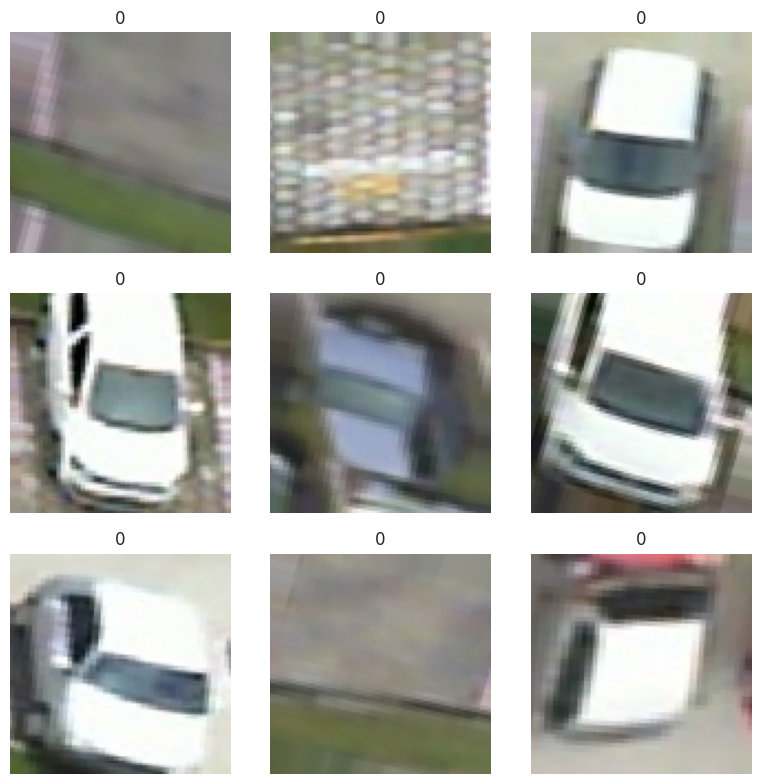

In [68]:
import matplotlib.pyplot as plt

# Create a figure with 3 rows and 3 columns
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(8, 8))

# Display the first 9 images in x_train
for i, ax in enumerate(axes.flat):
    ax.imshow(x_train[i+12])
    ax.set_title(np.argmax(y_train_resampled[i+12]))
    ax.axis('off')

# Show the figure
plt.tight_layout()
plt.show()

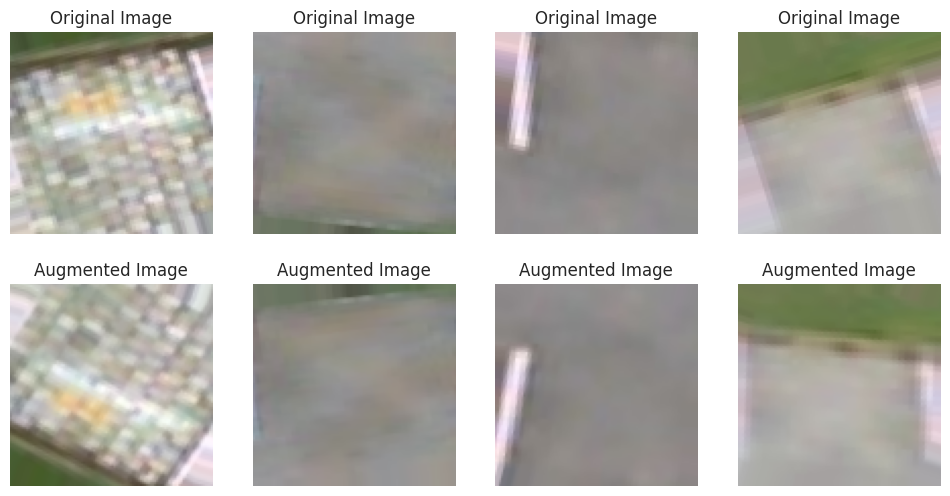

In [69]:
# Get the first batch of images from the generator
batch = train_generator.next()

# Extract the images from the batch
images = batch[0]

images = images.reshape((256, 100, 100, 3))

import matplotlib.pyplot as plt

# Create a figure to display the images
fig, axes = plt.subplots(2, 4, figsize=(12, 6))

# Display original and augmented images in pairs
for i in range(4):
    # Display original image
    axes[0, i].imshow(images[i])
    axes[0, i].axis('off')
    axes[0, i].set_title('Original Image')

    # Apply augmentation to the image and display the transformed image
    transformed_img = augment_datagen.random_transform(images[i])
    axes[1, i].imshow(transformed_img)
    axes[1, i].axis('off')
    axes[1, i].set_title('Augmented Image')

plt.show()

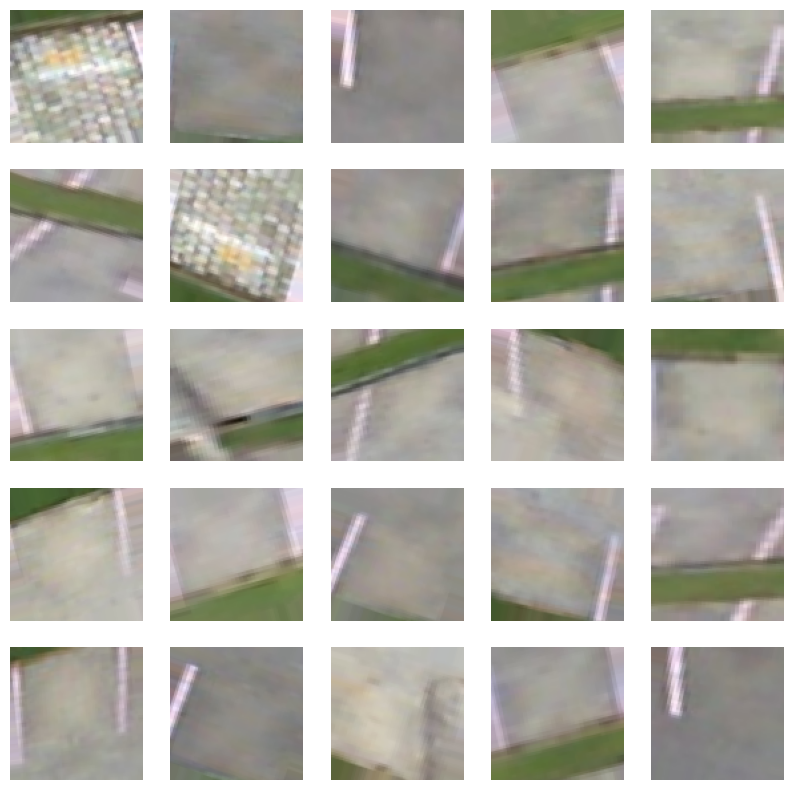

In [70]:
import matplotlib.pyplot as plt
# Create a figure to display the images
fig, axes = plt.subplots(5, 5, figsize=(10, 10))

# Display images in a 5x5 matrix
for i in range(25):
    row_idx = i // 5
    col_idx = i % 5
    axes[row_idx, col_idx].imshow(images[i])
    axes[row_idx, col_idx].axis('off')
    
plt.savefig('images_matrix.png')
plt.show()


## Create extractor

In [152]:
import xml.etree.ElementTree as ET
import cv2
import numpy as np
import os

def extract_parking_spaces(image_path, xml_path, save_dir='cropped_images', display_results=True, return_contours=False):
    # Load the image
    img = cv2.imread(image_path)
    img_contours = img.copy()
    # Load the XML file
    tree = ET.parse(xml_path)
    root = tree.getroot()

    # Define a list to store the cropped images
    cropped_images = []
    contours = []
    # Define a list of colors for the contours
    colors = [(0, 0, 255), (0, 255, 0), (255, 0, 0)]

    # Create save directory if it doesn't exist
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Iterate over the spaces in the XML file
    for i, space in enumerate(root.iter('space')):
        # Extract the rotated rectangle and contour from the XML file
        rotated_rect = space.find('rotatedRect')
        contour = space.find('contour')
        center = rotated_rect.find('center')
        size = rotated_rect.find('size')
        angle = rotated_rect.find('angle')

        # Extract the values from the XML elements
        cx, cy = int(center.attrib['x']), int(center.attrib['y'])
        w, h = int(size.attrib['w']), int(size.attrib['h'])
        angle_deg = float(angle.attrib['d'])

        # Convert the angle to radians
        angle_rad = angle_deg * (3.14159 / 180)

        # Extract the points from the contour
        pts = []
        for point in contour.iter('point'):
            x, y = int(point.attrib['x']), int(point.attrib['y'])
            pts.append((x, y))

        # Create a mask for the polygon
        mask = np.zeros(img.shape[:2], dtype=np.uint8)
        cv2.fillPoly(mask, [np.array(pts)], (255, 255, 255))
        
        # Rotate the mask by the angle
        M = cv2.getRotationMatrix2D((cx, cy), angle_deg, 1)
        rotated_mask = cv2.warpAffine(mask, M, (img.shape[1], img.shape[0]))

        # Crop the region from the image
        cropped = cv2.bitwise_and(img, img, mask=rotated_mask)

        # Find the bounding box of the contour
        x, y, w, h = cv2.boundingRect(np.array(pts))
        # Crop the region of interest from the cropped image
        roi = img[y:y+h, x:x+w]

        # Resize the region of interest to 100x100
        resized_roi = cv2.resize(roi, (100, 100))

        # Append the cropped image to the list
        cropped_images.append(resized_roi)
        
        # Draw the contour on the image
        cv2.drawContours(img_contours, [np.array(pts)], 0, colors[i % len(colors)], 2)
        
        contours.append(np.array(pts))

    if display_results:
        plt.grid(linewidth=0)
        plt.imshow(img_contours)
        plt.show()

    # Convert the list of cropped images to a numpy array
    cropped_images_array = np.array(cropped_images)
    
    contours = np.array(contours)
    
    if return_contours:
            return cropped_images_array, contours
    
    return cropped_images_array

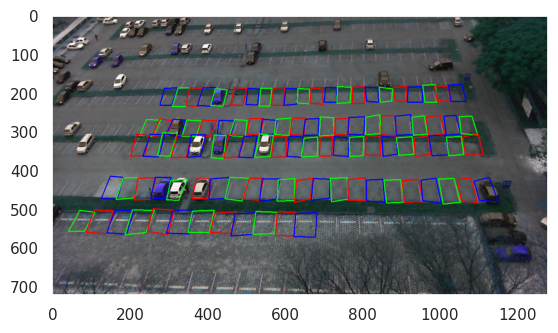

In [153]:
image_path = '/kaggle/input/parking-lot-dataset/PKLot/PKLot/PUCPR/Cloudy/2012-09-12/2012-09-12_07_07_55.jpg'
xml_path = '/kaggle/input/parking-lot-dataset/PKLot/PKLot/PUCPR/Cloudy/2012-09-12/2012-09-12_07_07_55.xml'

res = extract_parking_spaces(image_path, xml_path, display_results=True)

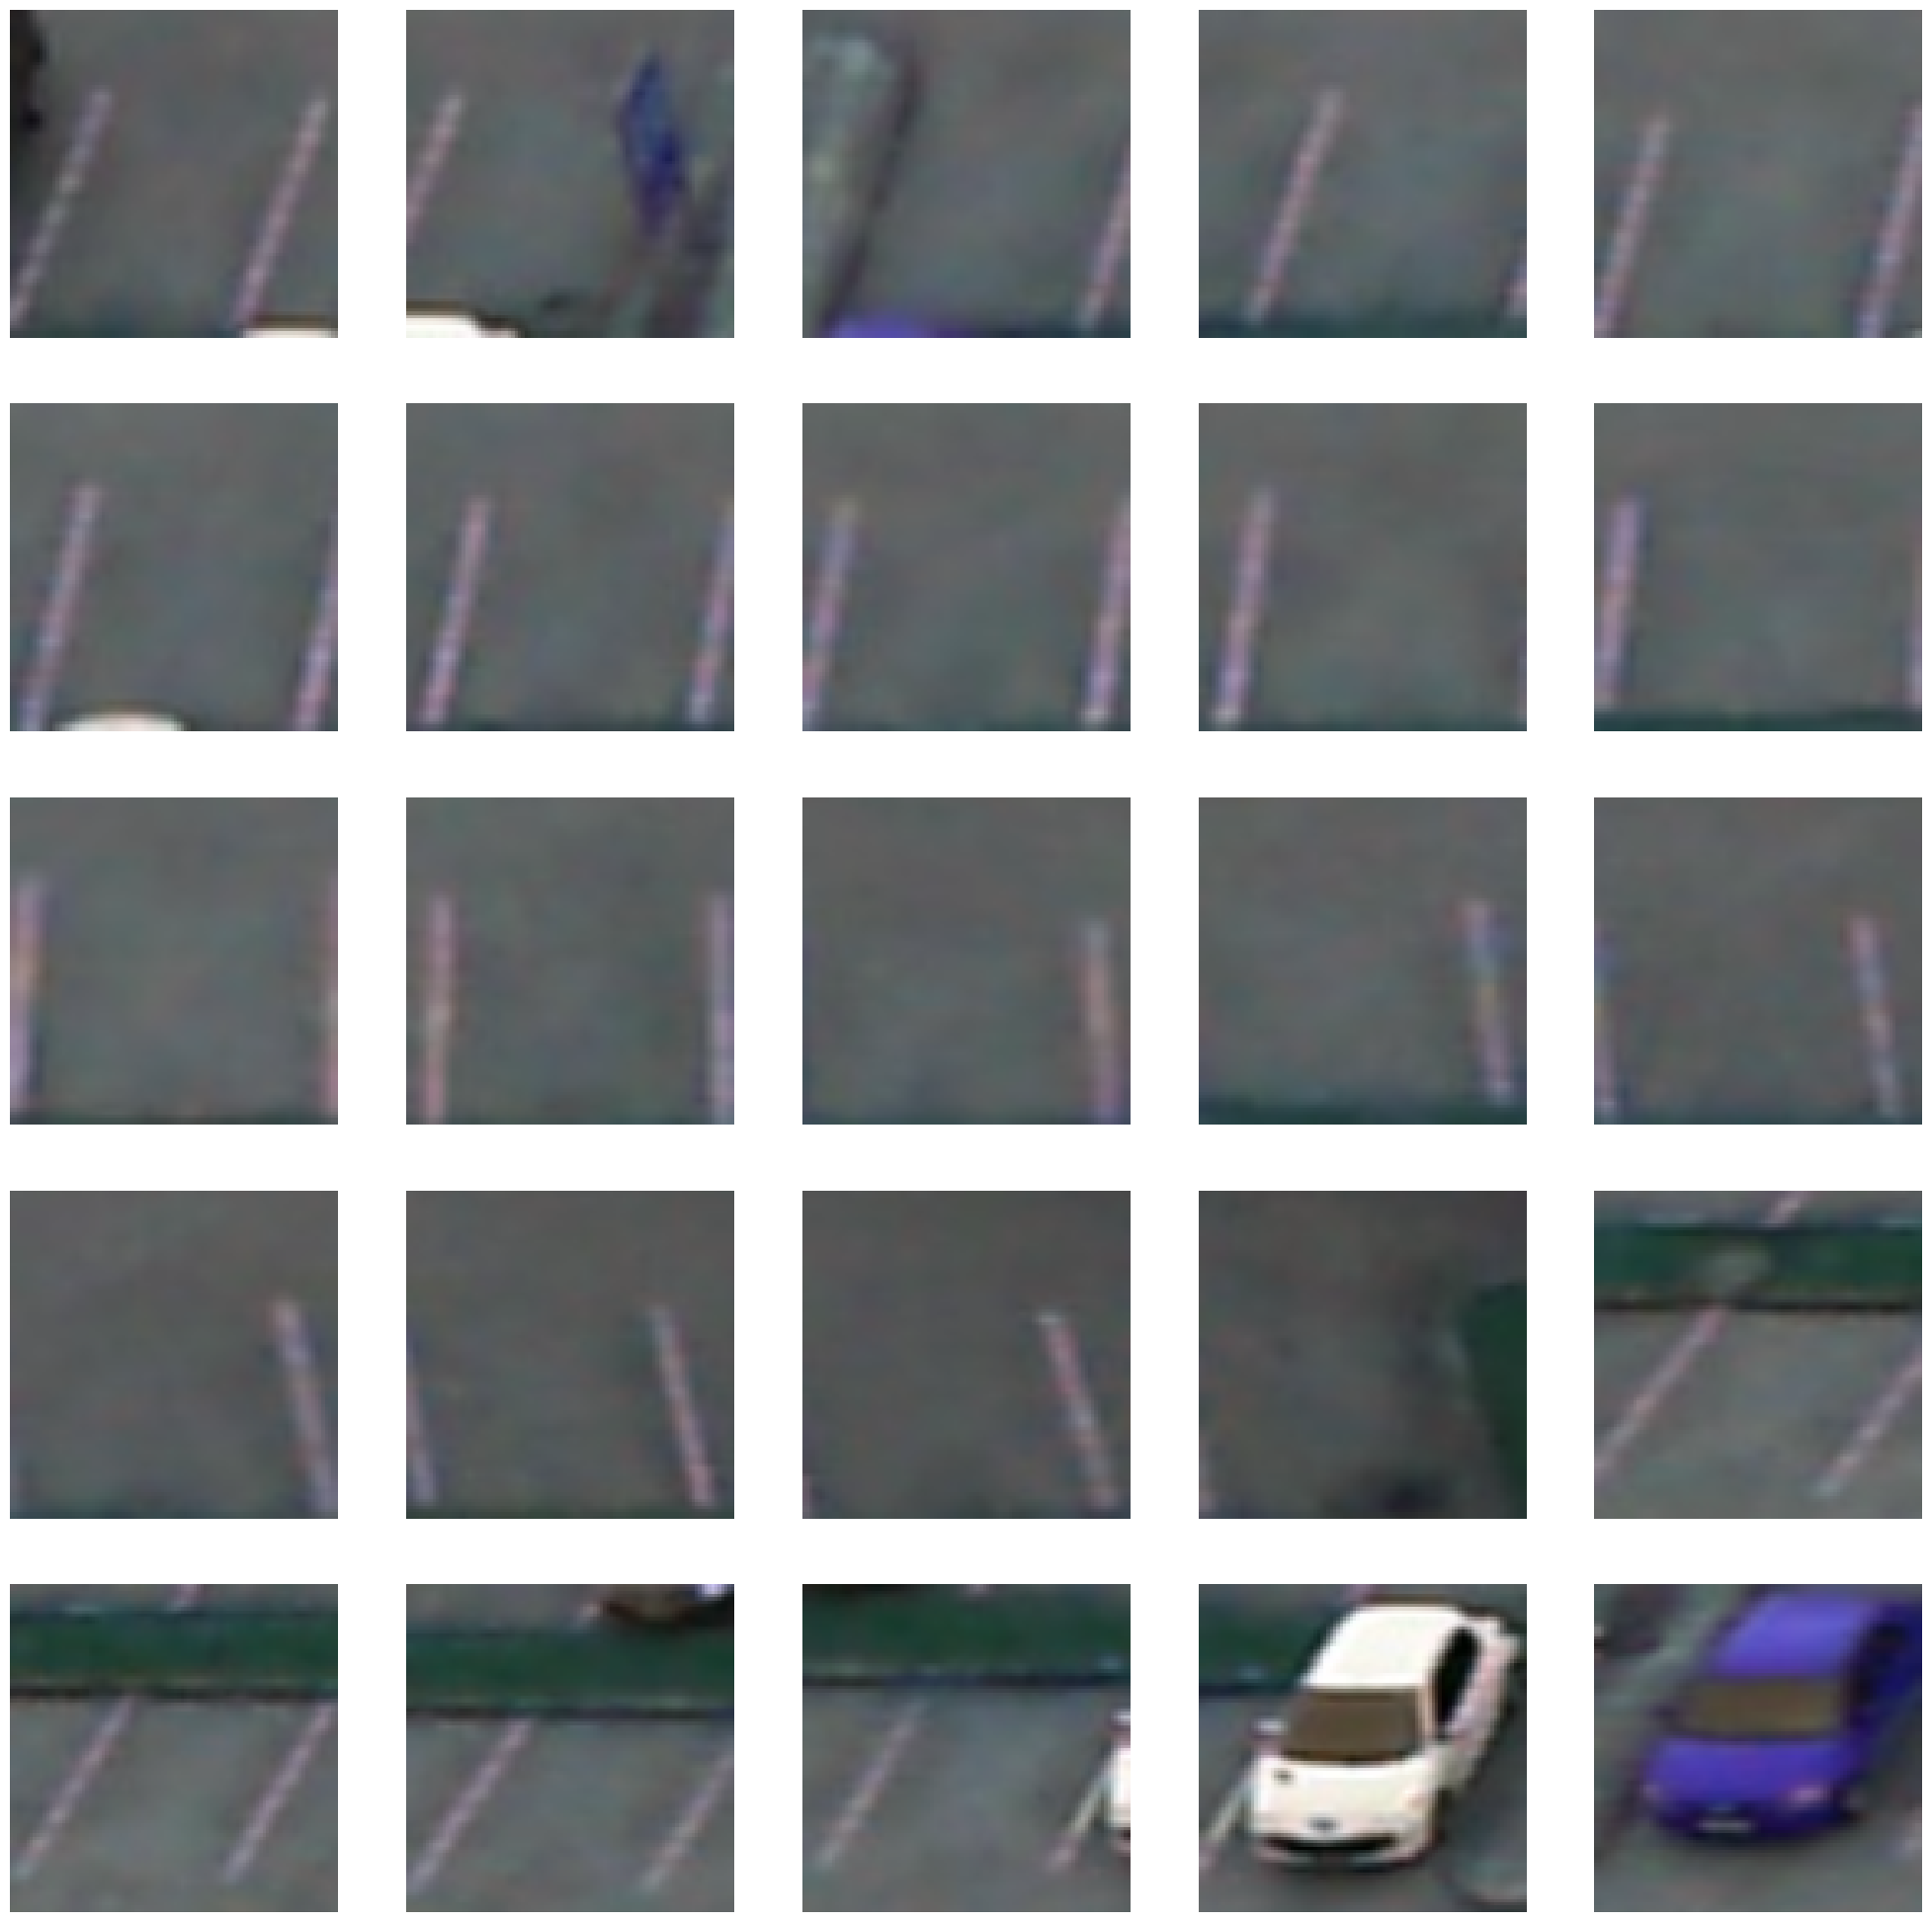

In [154]:
fig, axs = plt.subplots(5, 5, figsize=(25, 25))
axs = axs.flatten()

for i in range(25):
    axs[i].imshow(res[i+25])
    axs[i].axis('off')

plt.show()

# Create models

## ConvNeXt

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.applications import ConvNeXtTiny
from tensorflow.keras.utils import plot_model

# Define the input shape
input_shape = (100, 100, 3)

# Load the pre-trained ConvNeXt50 model
base_model = ConvNeXtTiny(weights="imagenet", include_top=False, input_shape=input_shape)

# Freeze the weights of the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Add a classification head to the model
x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(units=256, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(units=2, activation="softmax")(x)

# Define the complete model
model_convnext = keras.Model(inputs=base_model.input, outputs=outputs)

# Print the model summary
model_convnext.summary()
plot_model(model_convnext, to_file="model_convnext.png", show_shapes=True, show_layer_names=True)

## EfficientNet

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras.utils import plot_model

# Define the input shape
input_shape = (100, 100, 3)

# Load the pre-trained ConvNeXt50 model
base_model = EfficientNetV2S(weights="imagenet", include_top=False, input_shape=input_shape)

# Freeze the weights of the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Add a classification head to the model
x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(units=256, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(units=2, activation="softmax")(x)

# Define the complete model
model_efficientnet = keras.Model(inputs=base_model.input, outputs=outputs)

# Print the model summary
model_efficientnet.summary()
plot_model(model_efficientnet, to_file="model_efficientnet.png", show_shapes=True, show_layer_names=True)

## Simple model

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

simple_model = keras.Sequential([
    layers.Flatten(input_shape=input_shape),
    layers.Dense(units=64, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(units=32, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(units=2, activation="softmax")
])
# Print the model summary
simple_model.summary()
plot_model(simple_model, to_file="simple_model.png", show_shapes=True, show_layer_names=True)

In [76]:
models = {'SimpleModel': simple_model,
        'EfficientNetV2S': model_efficientnet,
         'ConvNeXtTiny': model_convnext}

## Train models

In [77]:
from keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping
from timeit import default_timer as timer

class TimingCallback(Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

early_stopping = EarlyStopping(
                                patience=25, # wait for 5 epochs
                                min_delta = 0.01, # if in 5 epochs the loss function doesn't inrease (for accuracy) 
                                               # or decrease (for val_loss) by 1%, then stop
                                verbose=1, # print the training epoch on which training was stopped
                                mode = 'min',
                                monitor='val_loss')

reduce_learning_rate = ReduceLROnPlateau(
                                    monitor="val_loss",
                                    patience=10, # if val_loss plateaus for 3 epochs such that it doesn't see 
                                                # an improvement of size = epsilon
                                    episilon= 0.1,
                                    factor=0.1,  # then we reduce the learning rate by a factor of 0.1
                                    cooldown = 2, # and we wait for 4 epochs before we restart again
                                    verbose=1)

time_callback = TimingCallback()

        
# hyperparameters
lr = 0.001
batch_size = 256

Training SimpleModel
Epoch 1/50
9/9 [==============================] - 3s 165ms/step - loss: 0.5931 - accuracy: 0.7754 - val_loss: 4.3252 - val_accuracy: 0.6379 - lr: 0.0010
Epoch 2/50
9/9 [==============================] - 0s 50ms/step - loss: 0.4279 - accuracy: 0.8611 - val_loss: 2.0493 - val_accuracy: 0.6430 - lr: 0.0010
Epoch 3/50
9/9 [==============================] - 1s 62ms/step - loss: 0.3596 - accuracy: 0.8924 - val_loss: 1.0364 - val_accuracy: 0.7220 - lr: 0.0010
Epoch 4/50
9/9 [==============================] - 0s 47ms/step - loss: 0.3156 - accuracy: 0.8947 - val_loss: 0.9482 - val_accuracy: 0.7503 - lr: 0.0010
Epoch 5/50
9/9 [==============================] - 0s 47ms/step - loss: 0.2779 - accuracy: 0.9105 - val_loss: 0.4138 - val_accuracy: 0.8713 - lr: 0.0010
Epoch 6/50
9/9 [==============================] - 1s 61ms/step - loss: 0.2481 - accuracy: 0.9236 - val_loss: 0.5285 - val_accuracy: 0.8420 - lr: 0.0010
Epoch 7/50
9/9 [==============================] - 0s 47ms/step - l

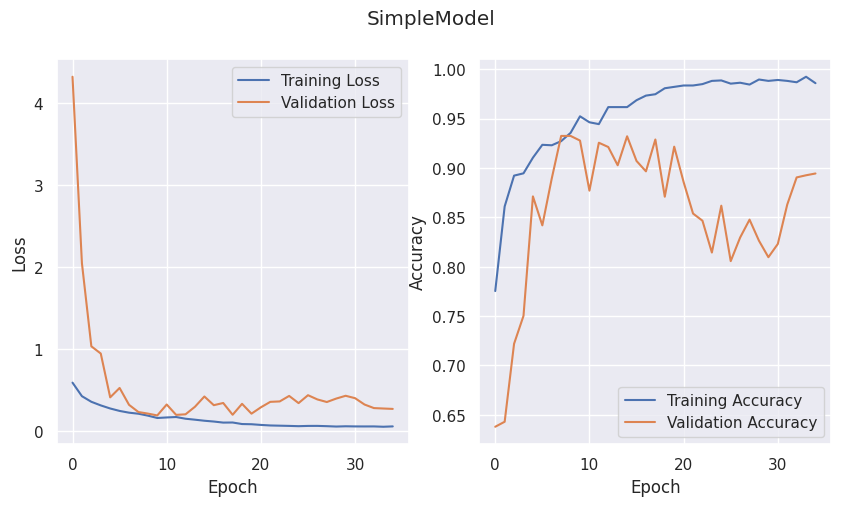

Training EfficientNetV2S
Epoch 1/50


2023-05-13 15:28:00.977421: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


9/9 [==============================] - 21s 867ms/step - loss: 0.4974 - accuracy: 0.8113 - val_loss: 0.6609 - val_accuracy: 0.3621 - lr: 0.0010
Epoch 2/50
9/9 [==============================] - 3s 370ms/step - loss: 0.4025 - accuracy: 0.8500 - val_loss: 0.6844 - val_accuracy: 0.3621 - lr: 0.0010
Epoch 3/50
9/9 [==============================] - 4s 461ms/step - loss: 0.3891 - accuracy: 0.8490 - val_loss: 0.6837 - val_accuracy: 0.3621 - lr: 0.0010
Epoch 4/50
9/9 [==============================] - 4s 464ms/step - loss: 0.3785 - accuracy: 0.8509 - val_loss: 0.6982 - val_accuracy: 0.3621 - lr: 0.0010
Epoch 5/50
9/9 [==============================] - 4s 459ms/step - loss: 0.3657 - accuracy: 0.8583 - val_loss: 0.7067 - val_accuracy: 0.3621 - lr: 0.0010
Epoch 6/50
9/9 [==============================] - 3s 370ms/step - loss: 0.3429 - accuracy: 0.8649 - val_loss: 0.6991 - val_accuracy: 0.3621 - lr: 0.0010
Epoch 7/50
9/9 [==============================] - 3s 378ms/step - loss: 0.3425 - accuracy: 0

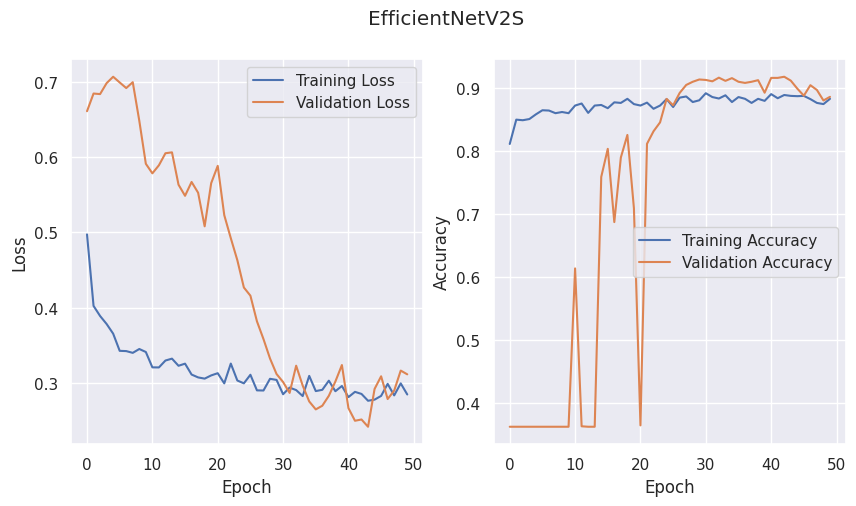

Training ConvNeXtTiny
Epoch 1/50
9/9 [==============================] - 23s 1s/step - loss: 0.5165 - accuracy: 0.7493 - val_loss: 1.1843 - val_accuracy: 0.3621 - lr: 0.0010
Epoch 2/50
9/9 [==============================] - 4s 530ms/step - loss: 0.3829 - accuracy: 0.8253 - val_loss: 0.9157 - val_accuracy: 0.3621 - lr: 0.0010
Epoch 3/50
9/9 [==============================] - 4s 502ms/step - loss: 0.3579 - accuracy: 0.8355 - val_loss: 0.7610 - val_accuracy: 0.3621 - lr: 0.0010
Epoch 4/50
9/9 [==============================] - 4s 495ms/step - loss: 0.3338 - accuracy: 0.8476 - val_loss: 0.7380 - val_accuracy: 0.3621 - lr: 0.0010
Epoch 5/50
9/9 [==============================] - 4s 503ms/step - loss: 0.3207 - accuracy: 0.8593 - val_loss: 0.7752 - val_accuracy: 0.3621 - lr: 0.0010
Epoch 6/50
9/9 [==============================] - 5s 541ms/step - loss: 0.3041 - accuracy: 0.8625 - val_loss: 0.7092 - val_accuracy: 0.3621 - lr: 0.0010
Epoch 7/50
9/9 [==============================] - 4s 494ms/ste

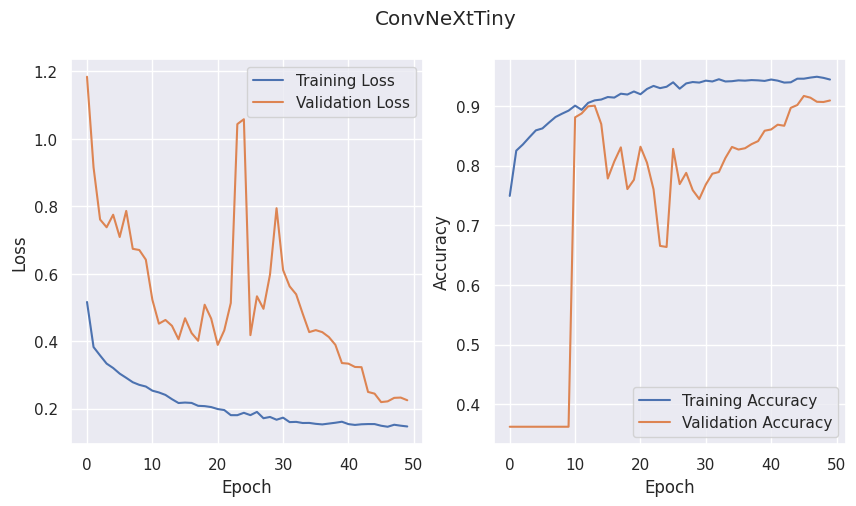

In [79]:
from keras.utils import to_categorical

# Define the number of epochs and batch size
epochs = 50
batch_size = 256

# Define the optimizer and loss function
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.CategoricalCrossentropy()

# define dictionary to hold accuracy results
accuracy_dict = {}
y_train_resampled = to_categorical(y_train_resampled)

for model_name, model in models.items():
    print(f'Training {model_name}')
    # compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    # convert labels to one-hot encoded format
    
    # train model
    history = model.fit(
        x_train, y_train_resampled,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_val, y_val),
        callbacks=[early_stopping, reduce_learning_rate, time_callback],
        verbose=1,
    )
    
    
    # Evaluate the model on the validation data
    loss, accuracy = model.evaluate(x_val, y_val)
    print('{} validation accuracy: {:.2f}%'.format(model_name, accuracy * 100))

    accuracy_dict[model_name] = accuracy
    
    
    # Plot the learning curves and accuracy curves
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.suptitle(model_name)
    plt.show()

In [88]:
accuracy_df = pd.DataFrame.from_dict(accuracy_dict, orient='index', columns=['Accuracy'])
accuracy_df

,Accuracy
SimpleModel,0.894527
EfficientNetV2S,0.886191
ConvNeXtTiny,0.909387


12/12 [==============================] - 9s 766ms/step


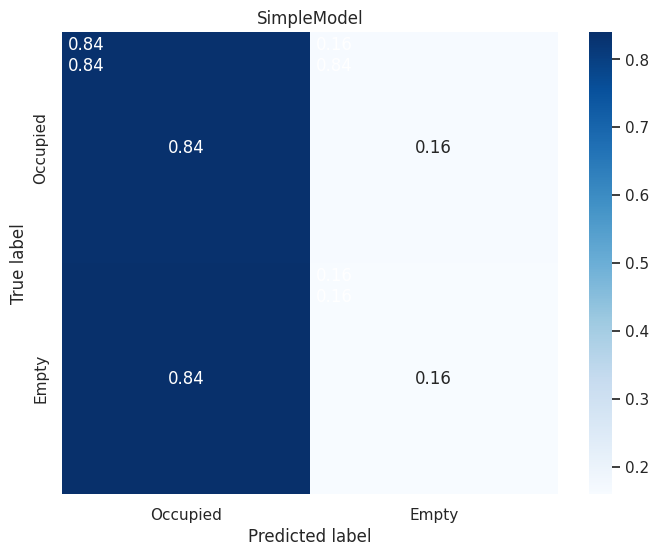

12/12 [==============================] - 10s 792ms/step


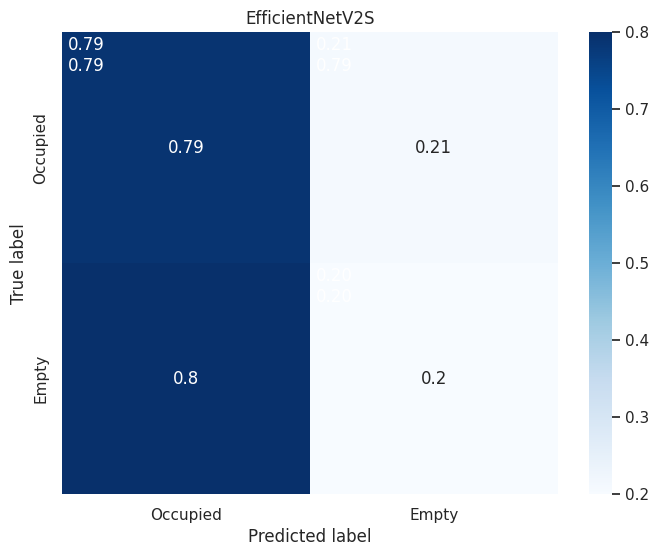

12/12 [==============================] - 10s 800ms/step


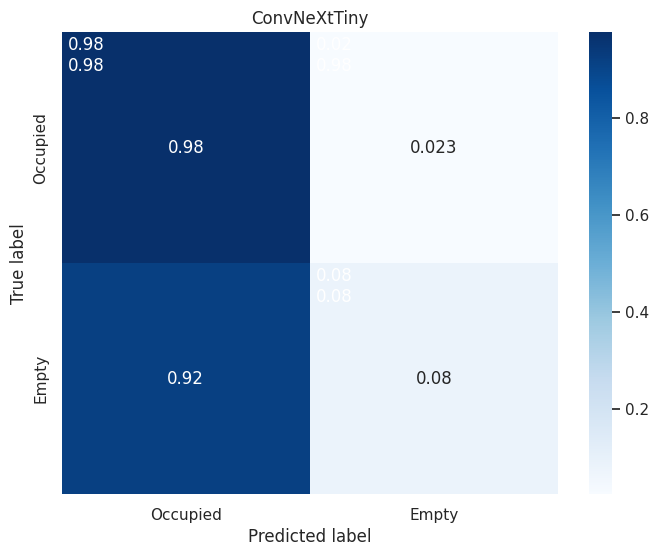

In [89]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Define the classes
class_names = ['Occupied', 'Empty']

# Define a function to plot the normalized confusion matrix
def plot_confusion_matrix(y_true, y_pred, title=''):
    # Calculate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Calculate accuracy for each class
    acc_per_class = np.diag(cm_norm)
    
    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_norm, annot=True, cmap=plt.cm.Blues, xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title(title)
    
    # Add accuracy per class to the plot
    for i, j in zip(*np.triu_indices_from(cm_norm)):
        plt.text(j+0.1, i+0.1, format(cm_norm[i, j], '.2f')+'\n'+format(acc_per_class[i], '.2f'), ha="center", va="center", color="white", fontsize=12)
    
    plt.show()

# Loop through each model and generate the predictions
for model_name, model in models.items():
    # Generate predictions on the validation data
    y_pred = np.argmax(model.predict(validation_generator), axis=1)
    y_true = validation_generator.classes
    
    # Plot the confusion matrix
    plot_confusion_matrix(y_true, y_pred, title=model_name)


In [82]:
y_train.shape

(2816, 2)

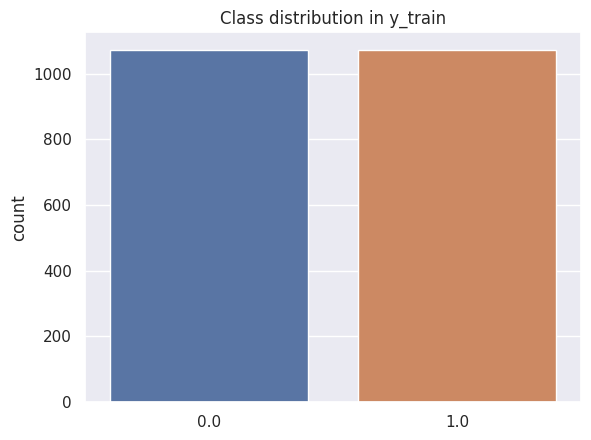

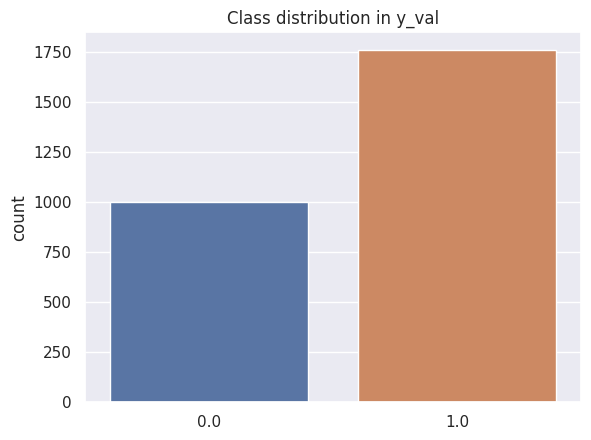

In [90]:
import seaborn as sns

sns.set(style='darkgrid')

# Plot the distribution of classes in y_train
sns.countplot(x=y_train_resampled[:,0])
plt.title('Class distribution in y_train')
plt.show()

# Plot the distribution of classes in y_val
sns.countplot(x=y_val[:,0])
plt.title('Class distribution in y_val')
plt.show()

 ## Testing model

In [149]:
def make_predictions(image_path, xml_path, classifier=None, display_results=True):
    lots, contours = extract_parking_spaces(image_path, xml_path, display_results=True, return_contours=True)
    img = cv2.imread(image_path)
    # Draw a green box if label is occupied, red if it's not
    if classifier is not None:
        for i, lot in enumerate(lots):
            # Use the classifier to make a prediction on the input image
            lot = np.expand_dims(lot, axis=0)
            prediction = classifier.predict(lot, verbose=0)
            prediction = np.argmax(prediction)

            # Draw a green box if label is occupied, red if it's not
            color = (0, 255, 0) if prediction == 1 else (0, 0, 255)
            cv2.drawContours(img, [contours[i]], 0, color, 2)
            
    if display_results:
        plt.grid(linewidth=0)
        plt.imshow(img)
        plt.show()

In [85]:
# models = {'SimpleModel': simple_model,
#         'EfficientNetV2S': model_efficientnet,
#          'ConvNeXtTiny': model_convnext}

In [155]:
image_path = '/kaggle/input/parking-lot-dataset/PKLot/PKLot/PUCPR/Cloudy/2012-09-12/2012-09-12_07_13_08.jpg'
xml_path = '/kaggle/input/parking-lot-dataset/PKLot/PKLot/PUCPR/Cloudy/2012-09-12/2012-09-12_07_13_08.xml'

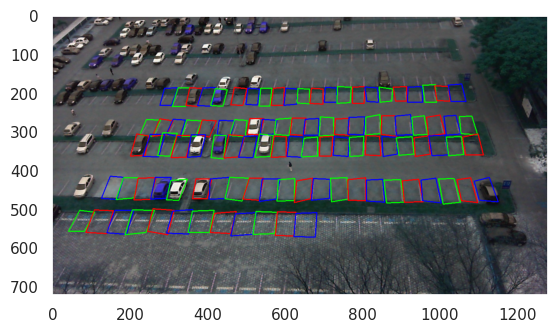

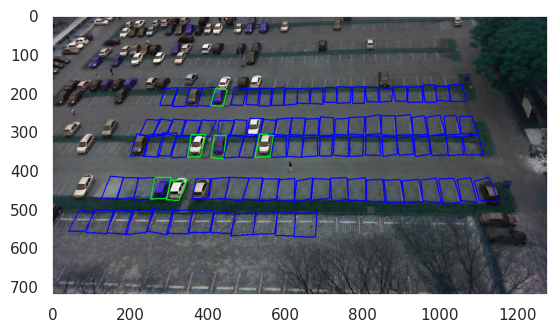

In [156]:
make_predictions(image_path, xml_path, classifier=models['SimpleModel'])